<a href="https://colab.research.google.com/github/agamthind96/Deep-Learning-Projects/blob/main/Basic_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis to classify movie review as Positive or Negative.

## Import the required tools for this project.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

### Check the version of TensorFlow.

In [ ]:
tf.__version__

'2.7.0'

## Download and explore the IMDB dataset

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'imdbEr.txt', 'README', 'test']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsup',
 'neg',
 'urls_neg.txt',
 'pos',
 'urls_unsup.txt',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsupBow.feat']

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f :
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Load the dataset.

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
os.listdir(train_dir)

['neg',
 'urls_neg.txt',
 'pos',
 'urls_unsup.txt',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsupBow.feat']

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/aclImdb/test',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


## Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like (br). These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', " ")
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to int to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
   standardize = custom_standardization,
   max_tokens = max_features,
   output_mode = 'int',
   output_sequence_length = sequence_length
)

Make a text-only dataset (without labels), then call adapt

In [ ]:
train_text = raw_train_ds.map(lambda x,y : x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
len(raw_train_ds)

625

In [ ]:
# Retrieve a batch (of 32 reviews and labels) from the dataset

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))


Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [ ]:
print("1299", vectorize_layer.get_vocabulary()[1299])

1299 self


In [ ]:
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

Vocabulary size: 10000


In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_train_ds.map(vectorize_text)
test_ds = raw_train_ds.map(vectorize_text)

## Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds =val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)


## Create the model.

In [ ]:
embedding_dim = 16

model = tf.keras.Sequential([
        layers.Embedding(max_features+1, embedding_dim),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.2),
        layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_3 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

## Loss function and optimizer

In [ ]:
model.compile(loss = losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))


## Train the model

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 17s 26ms/step - loss: 0.6652 - binary_accuracy: 0.6977 - val_loss: 0.6112 - val_binary_accuracy: 0.7814
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.5495 - binary_accuracy: 0.8002 - val_loss: 0.4853 - val_binary_accuracy: 0.8331
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4449 - binary_accuracy: 0.8443 - val_loss: 0.4003 - val_binary_accuracy: 0.8623
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3780 - binary_accuracy: 0.8654 - val_loss: 0.3472 - val_binary_accuracy: 0.8777
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3354 - binary_accuracy: 0.8790 - val_loss: 0.3113 - val_binary_accuracy: 0.8884
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3054 - binary_accuracy: 0.8882 - val_loss: 0.2845 - val_binary_accuracy: 0.8982
Epoch 7/10
625/625 [==============================] - 6s 9m

In [ ]:
# Let's evaluate our model.

loss, accuracy = model.evaluate(test_ds)
print("Loss : ", loss)
print("Accuracy : ", accuracy)

625/625 [==============================] - 7s 11ms/step - loss: 0.2163 - binary_accuracy: 0.9226
Loss :  0.2163422405719757
Accuracy :  0.9225999712944031


## Create a plot of loss and accuracy.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

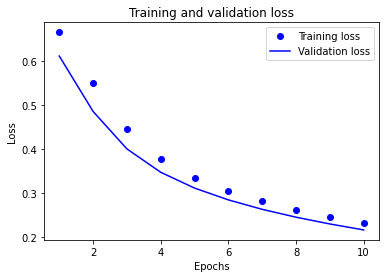

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

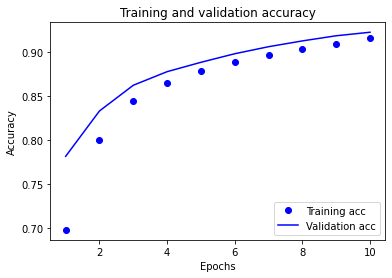

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 13ms/step - loss: 0.3101 - accuracy: 0.8733
0.8732799887657166
